## Part B4 - Price Modeling by Sampling

### Import Libraries & Loading Data

In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm

# Loading dataset
df = pd.read_csv("Data/Hotels_data_Changed.csv")

# Quick preview
print("Shape:", df.shape)
df.head()

Shape: (187848, 13)


,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,2015-07-17,2015-08-12,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,Wednesday,138,11.714771
1,2015-07-17,2015-08-19,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,Wednesday,131,11.769991
2,2015-07-17,2015-08-13,5,4370,4240,1,3,The Peninsula New York,5,27,Thursday,130,2.974828
3,2015-07-17,2015-07-26,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,Sunday,72,4.140311
4,2015-07-17,2015-08-12,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,Wednesday,67,3.852789


In [13]:
# Step 1: Filter only rows where Discount Price is not missing
df_valid = df[df['Discount Price'].notna()]

# Step 2: Count number of valid rows per hotel
hotel_counts = df_valid.groupby('Hotel Name').size().sort_values(ascending=False)

# Step 3: Get top 40 hotel names with the most valid entries
top_40_hotels = hotel_counts.head(40).index

# Step 4: Filter dataframe to only include those 40 hotels
df_top40 = df_valid[df_valid['Hotel Name'].isin(top_40_hotels)].copy()

# Check the result
print("Number of rows in df_top40:", df_top40.shape[0])
print("Unique hotels:", df_top40['Hotel Name'].nunique())
df_top40.head()


Number of rows in df_top40: 101564
Unique hotels: 40


,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
5,2015-07-17,2015-08-07,5,1436,1345,1,9,Grand Hyatt New York,4,21,Friday,91,6.337047
6,2015-07-17,2015-08-09,5,1616,1525,1,5,Grand Hyatt New York,4,23,Sunday,91,5.631188
7,2015-07-17,2015-08-12,5,1256,1183,1,5,Grand Hyatt New York,4,26,Wednesday,73,5.812102
8,2015-07-17,2015-08-13,5,1256,1201,1,54,Grand Hyatt New York,4,27,Thursday,55,4.378981
14,2015-07-17,2015-07-22,5,3900,3750,1,8,Park Hyatt New York,5,5,Wednesday,150,3.846154


In [15]:
# Ensure date columns are datetime
df_top40['Snapshot Date'] = pd.to_datetime(df_top40['Snapshot Date'])
df_top40['Checkin Date'] = pd.to_datetime(df_top40['Checkin Date'])

# Select one group for demonstration
hotel_name = 'Grand Hyatt New York'
snapshot_date = pd.to_datetime('2015-07-17')
discount_code = 1

# Filter rows for the selected group within 30 days
subset = df_top40[
    (df_top40['Hotel Name'] == hotel_name) &
    (df_top40['Snapshot Date'] == snapshot_date) &
    (df_top40['Discount Code'] == discount_code) &
    (df_top40['Checkin Date'] >= snapshot_date) &
    (df_top40['Checkin Date'] <= snapshot_date + pd.Timedelta(days=30))
].copy()

# Sort by Checkin Date
subset = subset.sort_values('Checkin Date')

# Create numerical feature for regression
subset['Checkin_Ordinal'] = subset['Checkin Date'].map(pd.Timestamp.toordinal)

# Define full data
X_full = subset[['Checkin_Ordinal']]
y_full = subset['Discount Price'].values

# Evaluate R² using different sample sizes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def evaluate_r2_with_k_samples(k):
    if k >= len(subset):
        return None
    sampled = subset.sample(n=k, random_state=42)
    X_sample = sampled[['Checkin_Ordinal']]
    y_sample = sampled['Discount Price']
    
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    
    y_pred = model.predict(X_full)
    return r2_score(y_full, y_pred)

# Run for sample sizes 3, 5, 7, 10
sample_sizes = [3, 5, 7, 10]
r2_results = {k: evaluate_r2_with_k_samples(k) for k in sample_sizes}

# Print results
print("R² scores for different sample sizes:")
for k, r2 in r2_results.items():
    if r2 is not None:
        print(f"{k} samples: R² = {r2:.4f}")
    else:
        print(f"{k} samples: Not enough data to evaluate R²")



R² scores for different sample sizes:
3 samples: R² = 0.4269
5 samples: Not enough data to evaluate R²
7 samples: Not enough data to evaluate R²
10 samples: Not enough data to evaluate R²


In [17]:
# Number of samples to use per group
SAMPLES_TO_USE = 5

# Get all unique combinations of Hotel + Snapshot Date + Discount Code
group_keys = df_top40.groupby(['Hotel Name', 'Snapshot Date', 'Discount Code']).size().reset_index(name='count')

# List to collect results
results = []

# Iterate over each group
for _, row in tqdm(group_keys.iterrows(), total=group_keys.shape[0]):
    hotel_name = row['Hotel Name']
    snapshot_date = row['Snapshot Date']
    discount_code = row['Discount Code']

    # Filter subset of data for this group (30 days after snapshot)
    subset = df_top40[
        (df_top40['Hotel Name'] == hotel_name) &
        (df_top40['Snapshot Date'] == snapshot_date) &
        (df_top40['Discount Code'] == discount_code) &
        (df_top40['Checkin Date'] >= snapshot_date) &
        (df_top40['Checkin Date'] <= snapshot_date + pd.Timedelta(days=30))
    ].copy()

    # Skip if not enough rows
    if len(subset) < SAMPLES_TO_USE:
        continue

    # Convert Checkin Date to numerical feature
    subset['Checkin_Ordinal'] = pd.to_datetime(subset['Checkin Date']).map(pd.Timestamp.toordinal)

    X_full = subset[['Checkin_Ordinal']]
    y_full = subset['Discount Price'].values

    # Sample k points for training
    sampled = subset.sample(n=SAMPLES_TO_USE, random_state=42)
    X_sample = sampled[['Checkin_Ordinal']]
    y_sample = sampled['Discount Price']

    # Train linear regression model
    model = LinearRegression()
    model.fit(X_sample, y_sample)

    # Predict and compute R²
    y_pred = model.predict(X_full)
    r2 = r2_score(y_full, y_pred)

    # Store result
    results.append({
        'Hotel Name': hotel_name,
        'Snapshot Date': snapshot_date,
        'Discount Code': discount_code,
        'Num Samples Used': SAMPLES_TO_USE,
        'Total Rows': len(subset),
        'R2 Score': r2
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Show summary
print("Number of models successfully trained:", len(results_df))
results_df.head()


100%|██████████| 19711/19711 [05:06<00:00, 64.27it/s]


Number of models successfully trained: 7503


,Hotel Name,Snapshot Date,Discount Code,Num Samples Used,Total Rows,R2 Score
0,Cassa Hotel 45th Street,2015-07-25,3,5,5,0.147673
1,Cassa Hotel 45th Street,2015-07-26,2,5,5,0.284000
2,Cassa Hotel 45th Street,2015-07-26,3,5,6,0.146274
3,Cassa Hotel 45th Street,2015-07-27,2,5,5,0.029698
4,Cassa Hotel 45th Street,2015-07-27,3,5,6,0.146274


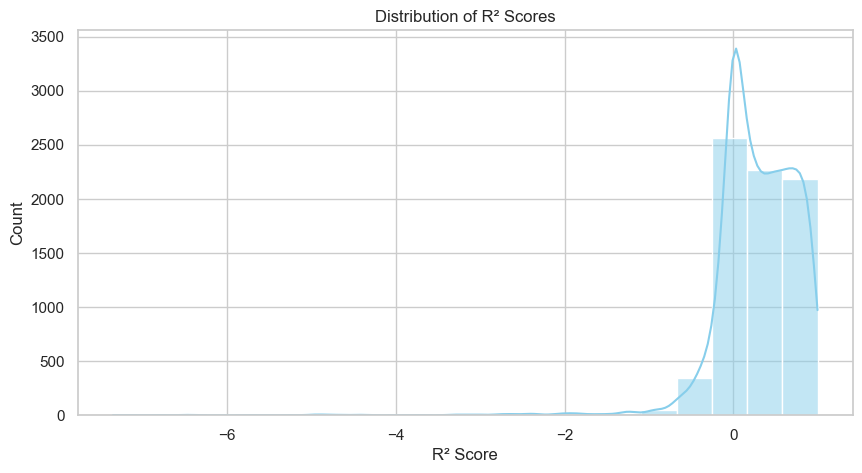

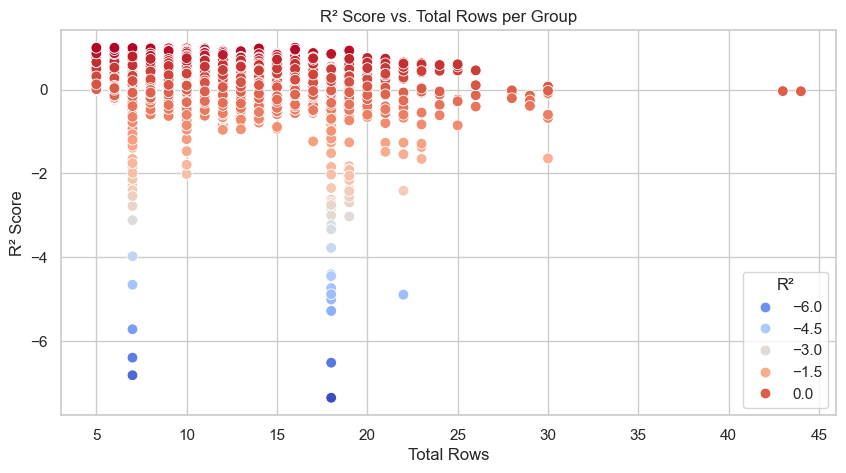

In [18]:
# Set plot style
sns.set(style="whitegrid")

# Histogram of R² scores
plt.figure(figsize=(10, 5))
sns.histplot(results_df['R2 Score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of R² Scores")
plt.xlabel("R² Score")
plt.ylabel("Count")
plt.show()

# Scatter plot: R² vs. number of rows
plt.figure(figsize=(10, 5))
sns.scatterplot(data=results_df, x='Total Rows', y='R2 Score', hue='R2 Score', palette='coolwarm', s=60)
plt.title("R² Score vs. Total Rows per Group")
plt.xlabel("Total Rows")
plt.ylabel("R² Score")
plt.legend(title='R²')
plt.show()

In [19]:
# Sort the results by R² score
sorted_results = results_df.sort_values(by='R2 Score', ascending=False)

# Top 5 best performing groups
top_5 = sorted_results.head(5)

# Bottom 5 worst performing groups
bottom_5 = sorted_results.tail(5)

print("Top 5 groups with highest R² scores:")
display(top_5)

print("\nBottom 5 groups with lowest R² scores:")
display(bottom_5)

Top 5 groups with highest R² scores:


,Hotel Name,Snapshot Date,Discount Code,Num Samples Used,Total Rows,R2 Score
3787,Loews Regency New York Hotel,2015-07-22,2,5,16,1.0
3780,Loews Regency New York Hotel,2015-07-19,2,5,7,1.0
3789,Loews Regency New York Hotel,2015-07-23,1,5,8,1.0
5811,The Carlyle A Rosewood Hotel,2015-11-26,3,5,6,1.0
3786,Loews Regency New York Hotel,2015-07-22,1,5,8,1.0



Bottom 5 groups with lowest R² scores:


,Hotel Name,Snapshot Date,Discount Code,Num Samples Used,Total Rows,R2 Score
5808,The Carlyle A Rosewood Hotel,2015-08-29,3,5,7,-5.719112
298,Conrad New York,2015-12-24,2,5,7,-6.396216
5652,Residence Inn Newark Elizabeth Liberty Interna...,2015-11-10,3,5,18,-6.517483
300,Conrad New York,2015-12-25,2,5,7,-6.817869
5290,Quality Inn Woodside,2015-10-26,2,5,18,-7.354235
